*Import the google drive to save and load data*

In [1]:
import os
print("Files in the current directory:", os.listdir('/content'))
from google.colab import drive
drive.mount('/content/drive')

Files in the current directory: ['.config', 'sample_data']
Mounted at /content/drive


*Download the neccessary libraries*

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.1 MB/s eta 0:00:00


*After that upload trhe Testing and Training folder to the given path*

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import optimizers

In [4]:
import numpy as np
X_train = np.load('/content/drive/MyDrive/MySentinel/Dataset/Training/training_features.npy')
y_train = np.load('/content/drive/MyDrive/MySentinel/Dataset/Training/training_labels.npy')
X_test = np.load('/content/drive/MyDrive/MySentinel/Dataset/Testing/testing_features.npy')
y_test = np.load('/content/drive/MyDrive/MySentinel/Dataset/Testing/testing_labels.npy')

*Let's see how many data we are working with, usually we have 4times more for training than testing*

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype)

(12000, 5, 5, 4)
(12000,)
(3000, 5, 5, 4)
(3000,)
uint16 int32 float32 int32


*Let's take a closer look*

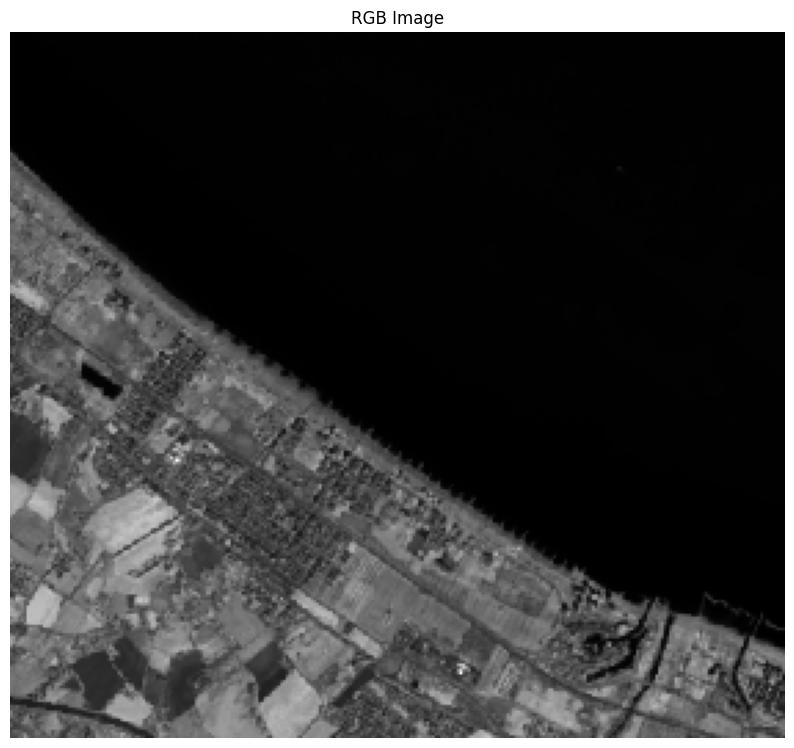

In [6]:
import rasterio
import matplotlib.pyplot as plt

raster_path = '/content/drive/MyDrive/MySentinel/Dataset/Training_photo/output_combined_bands.tif'

with rasterio.open(raster_path) as src:
    #1 blue 2 green 3 red 4 nir
    band_red = src.read(4)
    band_green = src.read(4)
    band_blue = src.read(4)
    rgb_image = np.dstack((band_red, band_green, band_blue))

    rgb_image = rgb_image / rgb_image.max()

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title('RGB Image')
    plt.axis('off')
    plt.show()


*Let's turn this data into a matrix*

In [7]:
with rasterio.open(raster_path) as src:
    band_red = src.read(3)
    band_green = src.read(2)
    band_blue = src.read(1)
    band_nir = src.read(4)

print(band_red[100:105, :5])
print(band_red.shape)

print(band_green[:5, :5])
print(band_green.shape)

print(band_blue[:5, :5])
print(band_blue.shape)

print(band_nir[:5, :5])
print(band_nir.shape)

[[ 8480 13159  5230  9856  5256]
 [ 7510 10446  9345 12609 10525]
 [ 4352  9935  8847 12373  6842]
 [ 6776 12491 10617 15702  6947]
 [11744  6658  6226  6167 10158]]
(256, 281)
[[4076 3985 4011 4037 3985]
 [4116 3985 4102 4044 4050]
 [3899 4011 4063 4011 3873]
 [3945 4024 3978 3985 4050]
 [3834 4037 3919 4024 4037]]
(256, 281)
[[2150 2209 2261 2077 2300]
 [2038 2071 2189 2182 2287]
 [2143 2018 2084 2104 2123]
 [1992 1822 2012 2005 2150]
 [1973 2189 1973 2032 2222]]
(256, 281)
[[157 183 183 190 197]
 [164 164 177 183 183]
 [118 164 170 177 183]
 [125 170 203 157 170]
 [138 177 190 164 157]]
(256, 281)


*Let's check some statistics about these matrices*

In [9]:
print(band_red.shape)
print(np.max(band_red), np.min(band_red), round(np.average(band_red)), round(np.std(band_red)))
print(np.max(band_green), np.min(band_green), round(np.average(band_green)))
print(np.max(band_blue), np.min(band_blue), round(np.average(band_blue)))
print(np.max(band_nir), np.min(band_nir), round(np.average(band_nir)))

(256, 281)
49597 236 3781 4340
45979 747 5286
43751 157 3387
52690 0 8487


*I'll try doing a basic recognition on this picture*

In [116]:
X_train = np.load('/content/drive/MyDrive/MySentinel/Dataset/Training/training_features.npy')
y_train = np.load('/content/drive/MyDrive/MySentinel/Dataset/Training/training_labels.npy')
X_test = np.load('/content/drive/MyDrive/MySentinel/Dataset/Testing/testing_features.npy')
y_test = np.load('/content/drive/MyDrive/MySentinel/Dataset/Testing/testing_labels.npy')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype)

X_train = X_train / 65535
X_test = X_test / 65535

(12000, 5, 5, 4)
(12000,)
(3000, 5, 5, 4)
(3000,)
uint16 int32 float32 int32


In [108]:
print(X_test[0])
print(y_test[0])

[[[ 766. 1015. 1082. 1222.]
  [ 970. 1246. 1350. 1450.]
  [1162. 1412. 1618. 1798.]
  [1144. 1460. 1588. 1854.]
  [1128. 1458. 1606. 1781.]]

 [[ 792. 1040. 1116. 1236.]
  [1008. 1312. 1492. 1585.]
  [1390. 1710. 1930. 2062.]
  [1488. 1812. 2106. 2254.]
  [1412. 1704. 2026. 2176.]]

 [[ 841. 1084. 1176. 1245.]
  [1130. 1418. 1650. 1759.]
  [1474. 1822. 2076. 2154.]
  [1592. 1982. 2226. 2358.]
  [1568. 1950. 2294. 2508.]]

 [[ 979. 1236. 1336. 1400.]
  [1314. 1604. 1872. 1970.]
  [1526. 1860. 2120. 2174.]
  [1568. 1958. 2210. 2308.]
  [1678. 2108. 2418. 2614.]]

 [[1116. 1378. 1490. 1600.]
  [1396. 1754. 1982. 2056.]
  [1554. 1922. 2176. 2280.]
  [1598. 1974. 2282. 2364.]
  [1682. 2044. 2424. 2533.]]]
0


*Let's see what's the average of each band*

In [21]:
print(X_train[0, :, :, 0])
print(X_train[0, :, :, 1])
print(X_train[0, :, :, 2])
print(X_train[0, :, :, 3])
print(np.std(X_train[:,:,:,0]))

[[0.01350423 0.01376364 0.01368734 0.01387045 0.01428244]
 [0.01387045 0.0140383  0.01435874 0.01443503 0.01367208]
 [0.01406882 0.01414511 0.01426719 0.01385519 0.01385519]
 [0.01396201 0.01428244 0.01417563 0.01350423 0.01412985]
 [0.01420615 0.01440452 0.01388571 0.01426719 0.01426719]]
[[0.01718166 0.01766995 0.01818875 0.01831083 0.0184329 ]
 [0.01837186 0.01867704 0.01879911 0.01855497 0.01828031]
 [0.01907378 0.01803616 0.01840238 0.01867704 0.0184329 ]
 [0.01879911 0.01818875 0.01846342 0.0187686  0.01855497]
 [0.01852445 0.01867704 0.0184329  0.01922637 0.01901274]]
[[0.01983673 0.02032502 0.0209659  0.02102693 0.02154574]
 [0.02084382 0.02121004 0.0214847  0.02136263 0.02130159]
 [0.02160678 0.02154574 0.02154574 0.02102693 0.02102693]
 [0.02121004 0.02136263 0.02136263 0.02197299 0.02178988]
 [0.02117952 0.02093538 0.02136263 0.02154574 0.02188144]]
[[0.02127108 0.0218967  0.02230869 0.02258335 0.02261387]
 [0.02252232 0.02206455 0.02236973 0.02279698 0.02261387]
 [0.0226443

*For some reason*

In [126]:
from keras.utils import to_categorical
print(y_train.shape)
print(y_train[11900])
if y_train.ndim == 1:
  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)
print(len(y_train))
print(y_train[0])

(12000,)
4
12000
[1. 0. 0. 0. 0.]


*This shows that originaly, there are only 4 classes*

In [127]:
first_class = np.where(y_train[:, 0] == 1)[0]
print(first_class)
print(y_train[2999])
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

[   0    1    2 ... 2397 2398 2399]
[0. 1. 0. 0. 0.]


*Something*

In [150]:
model = Sequential([
    Conv2D(16, (2,2), activation='relu', padding='same', input_shape=(5,5,4)),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

print(history.history.keys())
print(history.history["loss"])
print(history.history["accuracy"])



(12000, 5, 5, 4)
(12000, 5)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4243 - loss: 1.6030 - val_accuracy: 0.5187 - val_loss: 1.5782
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5404 - loss: 1.5571 - val_accuracy: 0.5373 - val_loss: 1.4954
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5591 - loss: 1.4514 - val_accuracy: 0.5787 - val_loss: 1.3570
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5786 - loss: 1.3052 - val_accuracy: 0.5833 - val_loss: 1.2027
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6092 - loss: 1.1470 - val_accuracy: 0.5953 - val_loss: 1.0652
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6395 - loss: 1.0259 - val_accuracy: 0.6750 - val_loss: 0.9533
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6755 - loss: 0.9202 - val_accuracy: 0.7260 - val_loss: 0.8599
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7246 - loss: 0.8319 - val_accuracy: 0.7507 - val_

*Let's see some predictions*

In [ ]:
start_idx = 2000
num_samples = 100
missed_count = 0
total_confidence_when_missed = 0
total_correct_class_confidence = 0

for i in range(start_idx, start_idx + num_samples):
    prediction = model.predict(X_train[i].reshape(1,5,5,4))
    predicted_class = np.argmax(prediction)
    actual_class = np.argmax(y_train[i])

    if predicted_class != actual_class:
        missed_count += 1
        total_confidence_when_missed += np.max(prediction)
        total_correct_class_confidence += prediction[0][actual_class]
    print(predicted_class)
    print(prediction)
    print()

miss_rate = (missed_count / num_samples) * 100
avg_wrong_confidence = total_confidence_when_missed / missed_count if missed_count > 0 else 0
avg_right_confidence_when_wrong = total_correct_class_confidence / missed_count if missed_count > 0 else 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
[[9.7188616e-01 2.7575718e-02 5.2385940e-04 8.1771478e-11 1.4216628e-05]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
[[9.7693217e-01 2.2651339e-02 4.0939482e-04 4.4222515e-11 7.1409931e-06]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2
[[0.0350606  0.36545658 0.58800745 0.00104104 0.01043427]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
[[9.5722973e-01 4.1826196e-02 9.0242428e-04 2.7638059e-10 4.1665284e-05]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
[[9.6199697e-01 3.7280809e-02 6.8436167e-04 1.4649726e-10 3.7788996e-05]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
[[9.5902193e-01 4.0228248e-02 7.0087466e-04 1.4552175e-10 4.8884369e-05]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
[[9.6832216e-01 3.1102978e-02 5.5346976e-04 8.5580598e-11 2.1373475e-05]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
[[9.7553504e-01 2.4005558e-02 4.5140853e-04 5.4730834e-11 8.0231193e-06]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
[[9.7832096e-01 2.1316977e-02 3.5559139e-04 3.1862176e-

*Now let's see a few statistics about the predictions*

In [ ]:
print(f"Total Misclassified: {missed_count}/{num_samples}")
print(f"Misclassification Rate: {miss_rate:.2f}%")
print(f"Avg Confidence of Wrong Prediction: {avg_wrong_confidence:.2f}")
print(f"Avg Confidence of Correct Class (when wrong): {avg_right_confidence_when_wrong:.2f}")